In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns; sns.set(style="white")

# Independence Tests

Discovering and deciphering relationships in data is often a difficult and opaque process. Identifying causality among variables is particularly important since it allows us to know which relationships to investigate further. This problem, called the independence testing problem, can be defined as follows: Consider random variables $X$ and $Y$ that have joint density $F_{XY} = F_{X|Y} F_Y$. The null hypothesis is thus that $X$ and $Y$ are independently distributed from one another; in other words, $F_{XY} = F_X F_Y$. The alternate hypothesis is that the $X$ and $Y$ are not indepenently distributed from on another. That is,

\begin{align*}
H_0: F_{XY} &= F_X F_Y \\
H_A: F_{XY} &\neq F_X F_Y
\end{align*}

Fortunately, `hyppo` provides an easy-to-use structure to use tests such as these. All tests have a class associated with it and have a `.test` method. The nuances of each test will be examined below; for the sake of this tutorial, the `MGC` class will be used.

Importing tests from `hyppo` is similar to importing any other test. `hyppo` also has a `sims` module, which contains several linear and nonlinear dependency structures to test the cases for which each test will perform best.

In [2]:
from hyppo.independence import MGC
from hyppo.sims import linear, spiral

First, let's generate some simulated data. The independence simulations included take on required paramaters number of samples and number of dimensions with optional paramaters mentioned in the [reference](https://mgc.neurodata.io/reference/sims.html#independence-simulations) section of the docs. Looking at some linearly distributed data first, let's look at 100 samples of noisey data and generate a unidimensional `x` and `y` (a 1000 sample of no noise simulated data is shown the trend in the data).

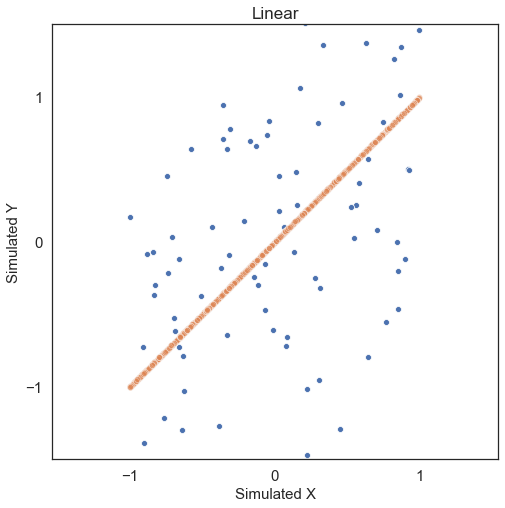

In [3]:
# mgc code used to produce the simulation data
x, y = linear(100, 1, noise=True)
x_no_noise, y_no_noise = linear(1000, 1, noise=False)


# stuff to make the plot and make it look nice
fig = plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x[:,0], y=y[:,0])
ax = sns.scatterplot(x=x_no_noise[:,0], y=y_no_noise[:,0], alpha=0.5)
ax.set_xlabel('Simulated X', fontsize=15)
ax.set_ylabel('Simulated Y', fontsize=15) 
plt.title("Linear", fontsize=17)
plt.axis('equal')
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])
plt.xticks([-1, 0, 1], fontsize=15)
plt.yticks([-1, 0, 1], fontsize=15)
plt.show()

The test statistic the p-value is calculated by running the `.test` method. Some important parameters for the `.test` method:

  - `reps`: The number of replications to run when running a permutation test
  - `workers`: The number of cores to parallelize over when running a permutation test

Note that when using a permutation test, the lowest p-value is the reciprocal of the number of repetitions. Also, since the p-value is calculated with a random permutation test, there will be a slight variance in p-values with subsequent runs.

In [4]:
# test statistic and p-values can be calculated for MGC, but a little slow ...
stat, pvalue, mgc_dict = MGC().test(x, y)

print("MGC test statistic:", stat)
print("MGC p-value:", pvalue)

MGC test statistic: 0.22264041449942273
MGC p-value: 0.001


In [5]:
# so fewer reps can be used, while giving a less confident p-value ...
stat, pvalue, mgc_dict = MGC().test(x, y, reps=100)

print("MGC test statistic:", stat)
print("MGC p-value:", pvalue)

/Users/sampan501/workspace/hyppo/hyppo/_utils.py:67: RuntimeWarning: The number of replications is low (under 1000), and p-value calculations may be unreliable. Use the p-value result, with caution!
  warnings.warn(msg, RuntimeWarning)


MGC test statistic: 0.22264041449942273
MGC p-value: 0.01


In [6]:
# or the parallelization can be used (-1 uses all cores)
stat, pvalue, mgc_dict = MGC().test(x, y, workers=-1)

print("MGC test statistic:", stat)
print("MGC p-value:", pvalue)

MGC test statistic: 0.22264041449942273
MGC p-value: 0.001


## Unique to MGC

MGC has a few more outputs stored conviently in `mgc_dict`. The contents of this are:

  - `mgc_map`: A representation of the latent geometry corresponding to the relationship between the inputs.
  - `opt_scale`: The estimated optimal scale as a `(x, y)` pair.
  - `null_dist`: The null distribution generated via permutation

The `mgc_map` calculates the test statistic over $k$ and $l$ nearest neighbors and the smoothed maximum of those test statistics corresponds to the optimal scale. This is shown in the plots below.

Optimal Scale: [100, 100]


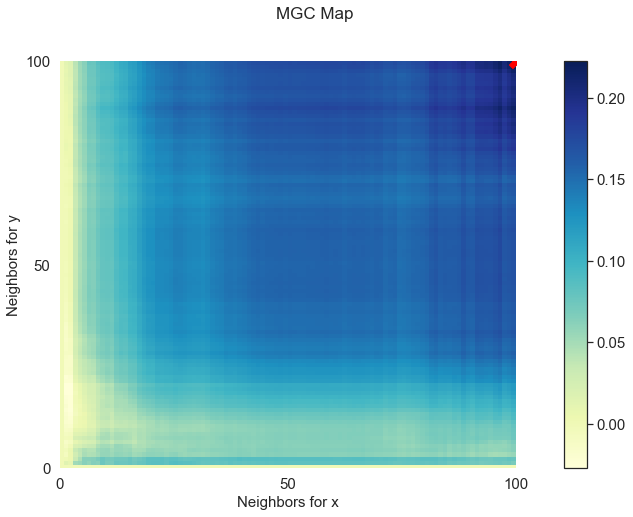

In [7]:
# store mgc outputs as variables
mgc_map = mgc_dict["mgc_map"]
opt_scale = mgc_dict["opt_scale"]

print("Optimal Scale:", opt_scale)
fig, (ax, cax) = plt.subplots(ncols=2, figsize=(9.45, 7.5),  gridspec_kw={"width_ratios":[1, 0.05]})

# draw heatmap and colorbar
ax = sns.heatmap(mgc_map, cmap="YlGnBu", ax=ax, cbar=False)
fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
ax.invert_yaxis()

# optimal scale
ax.scatter(opt_scale[0], opt_scale[1], marker='X', s=200, color='red') 

# make plots look nice
fig.suptitle("MGC Map", fontsize=17)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('Neighbors for x', fontsize=15)
ax.set_ylabel('Neighbors for y', fontsize=15) 
ax.set_xticks([0, 50, 100])
ax.set_yticks([0, 50, 100])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cax.xaxis.set_tick_params(labelsize=15)
cax.yaxis.set_tick_params(labelsize=15)
plt.show()

The optimal scale is shown on the plot as a red "x". For a linear relationship like this one, the optimal scale is equivalent to the global scale, which is $(n, n)$. We can use the same thing for nonlinear data as well (spiral in this case).

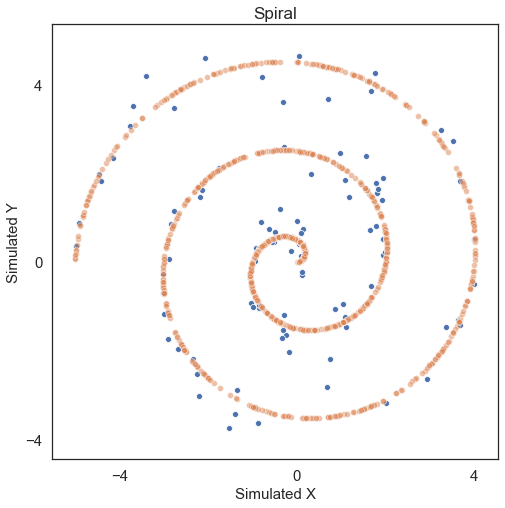

In [8]:
# mgc code used to produce the simulation data
x, y = spiral(100, 1, noise=True)
x_no_noise, y_no_noise = spiral(1000, 1, noise=False)


# stuff to make the plot and make it look nice
fig = plt.figure(figsize=(8,8))
ax = sns.scatterplot(x=x[:,0], y=y[:,0])
ax = sns.scatterplot(x=x_no_noise[:,0], y=y_no_noise[:,0], alpha=0.5)
ax.set_xlabel('Simulated X', fontsize=15)
ax.set_ylabel('Simulated Y', fontsize=15) 
plt.title("Spiral", fontsize=17)
plt.axis('equal')
plt.xticks([-4, 0, 4], fontsize=15)
plt.yticks([-4, 0, 4], fontsize=15)
plt.show()

In [9]:
stat, pvalue, _ = MGC().test(x, y)

print("MGC test statistic:", stat)
print("MGC p-value:", pvalue)

MGC test statistic: 0.10090932016246666
MGC p-value: 0.001


Optimal Scale: [100, 100]


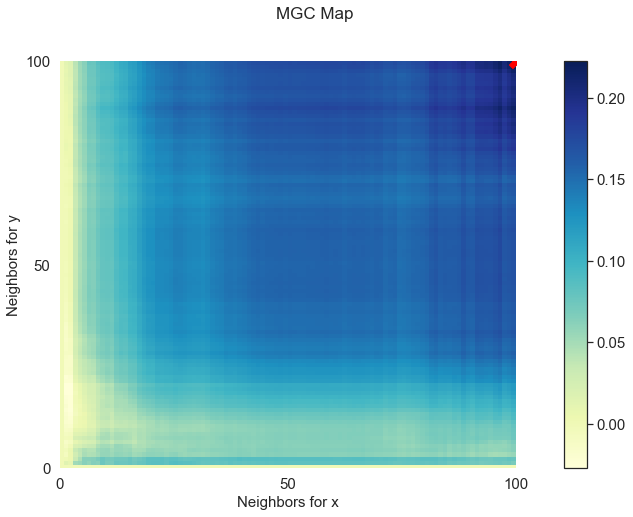

In [10]:
# store mgc outputs as variables
mgc_map = mgc_dict["mgc_map"]
opt_scale = mgc_dict["opt_scale"]

print("Optimal Scale:", opt_scale)
fig, (ax, cax) = plt.subplots(ncols=2, figsize=(9.45, 7.5),  gridspec_kw={"width_ratios":[1, 0.05]})

# draw heatmap and colorbar
ax = sns.heatmap(mgc_map, cmap="YlGnBu", ax=ax, cbar=False)
fig.colorbar(ax.get_children()[0], cax=cax, orientation="vertical")
ax.invert_yaxis()

# optimal scale
ax.scatter(opt_scale[0], opt_scale[1], marker='X', s=200, color='red') 

# make plots look nice
fig.suptitle("MGC Map", fontsize=17)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlabel('Neighbors for x', fontsize=15)
ax.set_ylabel('Neighbors for y', fontsize=15) 
ax.set_xticks([0, 50, 100])
ax.set_yticks([0, 50, 100])
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cax.xaxis.set_tick_params(labelsize=15)
cax.yaxis.set_tick_params(labelsize=15)
plt.show()

We get a unique MGC-map and the optimal scale has shifted! This is because for nonlinear relationships like this one, smaller $k$ and $l$ nearest neighbors more strongly define the relationship. As such, MGC sets the optimal scale to be local rather than global from before.

## Unique to Dcorr/Hsic

Dcorr and Hsic have a fast chi-square approximation that allows for quick calculation of the p-values without significant loss in statistical power. This can be called using setting `auto = True` when running the `.test` method, which runs the fast chi-square approximation whenever the sample size is larger than 20. Due to the implementation, the values of `reps` and `parameters` mentioned before are irrelevant. By default, the `auto` parameter is set to `True`.

In [11]:
from hyppo.independence import Dcorr

In [12]:
stat, pvalue = Dcorr().test(x, y, reps=10000, auto=False)

print("Dcorr test statistic:", stat)
print("Slow Dcorr p-value:", pvalue)

Dcorr test statistic: 0.0009905674536863085
Slow Dcorr p-value: 0.3609


In [13]:
stat, pvalue = Dcorr().test(x, y, auto=True)

print("Dcorr test statistic:", stat)
print("Fast Dcorr p-value:", pvalue)

Dcorr test statistic: 0.0009905674536863085
Fast Dcorr p-value: 0.29447320247465036
